In [1]:
# pip install tensorflow

In [2]:
# !pip install matplotlib

In [3]:
# !pip install opencv-python

In [4]:
# !pip install tqdm

In [5]:
# !pip install scikit-image

In [6]:
# !pip install segmentation_models

In [7]:
#!pip install sklearn

In [8]:
# !pip install scipy

In [205]:
#!pip install pandas

In [9]:
import scipy
scipy.__version__


'1.7.0'

## Part 1

### Face Detection

### import libraries

In [10]:
import os
import matplotlib.pyplot as plt
import cv2
import tqdm
import numpy as np
from skimage.transform import resize
from tensorflow.keras.applications.mobilenet import preprocess_input
#draw boundry on image
import matplotlib.patches as patches
%matplotlib inline

In [11]:
import tensorflow
tensorflow.__version__

'2.5.0'

In [12]:
# Initialize the random number generator
import random
random.seed(0)

In [13]:
#read npy file

In [14]:
#file_path="/content/gdrive/MyDrive/Part 1- Train data - images.npy"
file_path='Part 1- Train data - images.npy'
data1=np.load(file_path, allow_pickle=True)

## Creating Image Masking
##### Step 1: Getting coordinates

In [15]:
##original
noofboundries=[] #list to save number of boundries
data=[] ##image array
points_data=[] ## collect coordinates
label_data=[] ## labels information
notes_data=[] ## notes informaion
im_height=[] ##image height
im_width=[] ## image weight
X=[]

for i in range(len(data1)):
    data.append(data1[i][0])
    noofboundries.append(len(data1[i][1]))
    im_height.append(data1[i][1][0].get('imageHeight'))
    im_width.append(data1[i][1][0].get('imageWidth')) 
    X=[]
    for nboundry in range(noofboundries[i]):   
        for j in range(2):
            if j==0:
                x_min=int(data1[i][1][nboundry].get('points')[j].get('x')*im_width[i])
                y_min=int(data1[i][1][nboundry].get('points')[j].get('y')*im_height[i])
            if j==1:
                x_max=int(data1[i][1][nboundry].get('points')[j].get('x')*im_width[i])
                y_max=int(data1[i][1][nboundry].get('points')[j].get('y')*im_height[i])
        cord=[x_min,y_min,x_max,y_max]
        X.append(cord)
    points_data.append(X)

In [16]:
points_data[0]

[[56, 102, 112, 151], [379, 97, 428, 156]]

### Step2 : Creating Binary mask of an image¶

In [17]:
face_mask_img=[]

for img in range(len(data1)):
    image=data1[img][0]
    img2 = np.zeros_like(data1[img][0])
    for i in range(len(points_data[img])):
        target_i =image[points_data[img][i][1]:points_data[img][i][3], points_data[img][i][0]:points_data[img][i][2]] 
        img2[points_data[img][i][1]:points_data[img][i][3], points_data[img][i][0]:points_data[img][i][2]] =target_i
    face_mask_img.append(img2)

#Resize images
y_resize_image=[]
for i in range(len(face_mask_img)):
    y_resize_image.append(resize(face_mask_img[i], (128,128,1)))

In [18]:
face_mask_img_binary=[]
for i in range(len(y_resize_image)):
    mask_img = (y_resize_image[i]!=0)*1.0
    mask_img = 1.0*(mask_img[:,:,0]==0)
    face_mask_img_binary.append(mask_img)

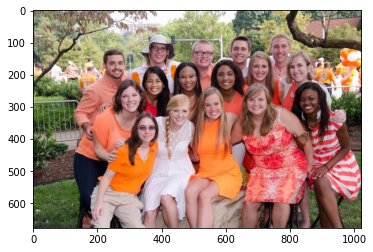

In [19]:
plt.imshow(data1[333][0])

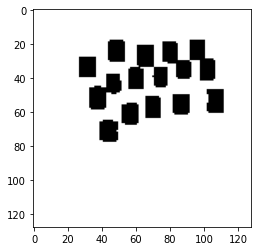

In [20]:
plt.imshow(face_mask_img_binary[333], cmap='gray')

In [21]:
face_mask_img_binary_ar=np.array(face_mask_img_binary)
face_mask_img_binary_ar.shape

(409, 128, 128)

#### Resize mask oof size 128X128 for mobile net

In [22]:
y_resize_image=[]
for i in range(len(face_mask_img_binary_ar)):
    y_resize_image.append(resize(face_mask_img[i], (128,128,1)))

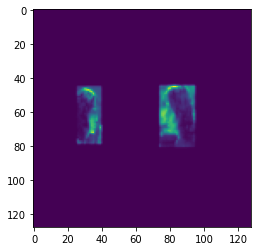

In [23]:
plt.imshow(y_resize_image[407])

In [24]:
y_resize_image1= np.array(y_resize_image)
y_resize_image1.shape

(409, 128, 128, 1)

#### Preprocess Training Images

In [25]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input
IMAGE_SIZE=128
X_train=[]
for f in range(len(data)):
    img = data[f] # Read image
    X_train.append(resize(img, (128,128,3)))# Resize image

In [26]:
len(X_train)

409

In [27]:
X_train = np.array(X_train)
X_train.shape

(409, 128, 128, 3)

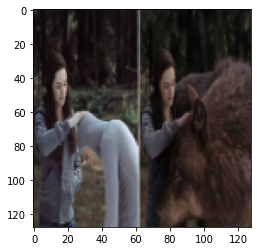

In [28]:
plt.imshow(X_train[0])

## Model Creation

In [29]:
import segmentation_models as sm

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [30]:
from segmentation_models import Unet,get_preprocessing
from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.losses import binary_crossentropy
from keras.models import model_from_json
from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

In [358]:
BACKBONE = 'mobilenet'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_train.shape

In [394]:
X_train.shape

(409, 128, 128, 3)

### Define metrices

In [32]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [33]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

#### Compile Model

In [469]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# checkpoint = ModelCheckpoint(filepath="/content/gdrive/MyDrive/models"+"model2406v2-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True,patience=5)
# callbacks=[ModelCheckpoint(filepath=os.getcwd()+"\\model2706v1.h5",verbose=1, save_best_only=True, save_weights_only=True,patience=5),
#            EarlyStopping(monitor="val_loss", patience=5),
#            ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-3, verbose=1)]
ReduceLR=ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-3, verbose=1)

In [339]:
from keras.layers import Reshape
# N = X_train.shape[-1]

base_model_dg = Unet(backbone_name='mobilenet',encoder_weights='imagenet',input_shape=(128, 128, 3))
base_model_dg.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 32)   864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 32)   128         conv1[0][0]                      
____________________________________________________________________________________________

In [423]:
base_model = Unet(backbone_name='mobilenet',encoder_weights='imagenet',input_shape=(128, 128, 3))
base_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 32)   864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 32)   128         conv1[0][0]                      
____________________________________________________________________________________________

In [424]:
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
base_model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [427]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
# optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# base_model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])
base_model.fit(X_train, y_resize_image1, validation_split=0.2, epochs=10, batch_size=32, verbose=1,callbacks=[callbacks])

Epoch 1/10
11/11 [==============================] - 72s 6s/step - loss: 3.0967 - dice_coefficient: 0.1043 - val_loss: 3.0778 - val_dice_coefficient: 0.0837

Epoch 00001: val_loss improved from inf to 3.07783, saving model to C:\Users\rajhi\Manasi\Computer Vision\computer vision\facedetection\model2706v1.h5
Epoch 2/10
11/11 [==============================] - 64s 6s/step - loss: 2.8201 - dice_coefficient: 0.1217 - val_loss: 3.0954 - val_dice_coefficient: 0.0862

Epoch 00002: val_loss did not improve from 3.07783
Epoch 3/10
11/11 [==============================] - 64s 6s/step - loss: 2.6391 - dice_coefficient: 0.1349 - val_loss: 3.1195 - val_dice_coefficient: 0.0869

Epoch 00003: val_loss did not improve from 3.07783
Epoch 4/10
11/11 [==============================] - 79s 7s/step - loss: 2.4812 - dice_coefficient: 0.1621 - val_loss: 3.0713 - val_dice_coefficient: 0.0874

Epoch 00004: val_loss improved from 3.07783 to 3.07126, saving model to C:\Users\rajhi\Manasi\Computer Vision\computer 

In [ ]:
# serialize model to YAML
model_yaml = base_model_dg.to_yaml()
with open(os.getcwd()+'\\face_detectionv7.yaml', "w") as yaml_file:
    yaml_file.write(os.getcwd()+'\\face_detectionv7.yaml')
    print("Saved yaml to disk")
# # serialize weights to HDF5
base_model_dg.save_weights(os.getcwd()+'\\face_detectionv7_weights.h5')
print("Saved model to disk")

In [447]:
optimizer = Adam(learning_rate=2e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
base_model_dg.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Image Datagenerator

In [446]:
from keras.preprocessing.image import ImageDataGenerator

In [450]:
## With image data genrator
# we create two instances with the same arguments
data_gen_args = dict(
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

In [451]:
seed=1
image_datagen = ImageDataGenerator(data_gen_args)
mask_datagen = ImageDataGenerator(data_gen_args)
image_generator = image_datagen.flow(X_train,seed=seed)
y_train_v1=np.array(face_mask_img_binary_ar)
mask_generator = mask_datagen.flow(y_resize_image1,seed=seed)

In [471]:
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
base_model_dg.fit(train_generator,steps_per_epoch=15,epochs=50,callbacks=[ReduceLR])

Epoch 1/50
15/15 [==============================] - 84s 6s/step - loss: 2.8332 - dice_coefficient: 0.1421
Epoch 2/50
15/15 [==============================] - 89s 6s/step - loss: 2.7227 - dice_coefficient: 0.1460
Epoch 3/50
15/15 [==============================] - 1756s 125s/step - loss: 2.5021 - dice_coefficient: 0.1661
Epoch 4/50
15/15 [==============================] - 75s 5s/step - loss: 2.3970 - dice_coefficient: 0.1734
Epoch 5/50
15/15 [==============================] - 75s 5s/step - loss: 2.2504 - dice_coefficient: 0.1881
Epoch 6/50
15/15 [==============================] - 85s 6s/step - loss: 2.2156 - dice_coefficient: 0.1873
Epoch 7/50
15/15 [==============================] - 90s 6s/step - loss: 2.0850 - dice_coefficient: 0.2060
Epoch 8/50
 3/15 [=====>........................] - ETA: 1:14 - loss: 2.0234 - dice_coefficient: 0.2124

KeyboardInterrupt: 

13/13 [==============================] - 15s 1s/step


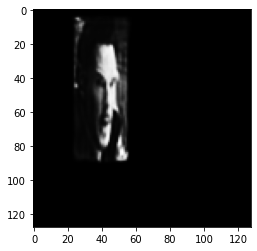

In [453]:
WEIGHTS_FILE = os.getcwd()+'\\face_detectionv3_weights.h5'
THRESHOLD = 0.8
EPSILON = 0.02

model_fc = base_model
model_fc.load_weights(WEIGHTS_FILE)
preds_train = model.predict(X_train, verbose=1)
image = cv2.resize(preds_train[64], (128,128))
plt.imshow(image,cmap='gray')

In [455]:
### Test image
from keras.preprocessing import image

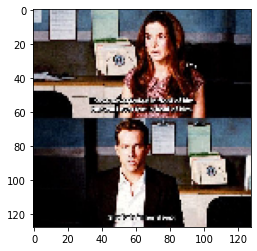

In [305]:
plt.imshow(img)

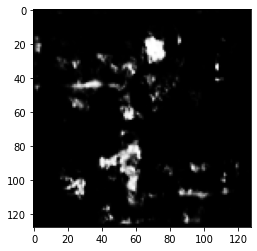

In [467]:
from keras.preprocessing import image
BACKBONE = 'mobilenet'
preprocess_input = get_preprocessing(BACKBONE)

file='Part 1Test Data - Prediction Image.jpeg'
img = image.load_img(file, target_size=(128,128,3))
x = image.img_to_array(img)
x= np.expand_dims(img, axis=0)
x.shape
# img1 = np.reshape(x,[1,128,128,3])
img2= preprocess_input(x)
img2.shape
preds_train = model_fc.predict(img2)
preds_train.shape
preds_train=np.reshape(preds_train,[128,128,1])
image_ez = cv2.resize(preds_train, (128,128))
plt.imshow(preds_train,cmap='gray')

In [393]:

import numpy as np
img = image.load_img('Part 1Test Data - Prediction Image.jpeg', target_size=(128,128,3))
x = image.img_to_array(img)
x1 = np.expand_dims(x, axis=0)
x2 = preprocess_input(x)
score= model_fc.predict(x2)
preds_train=np.reshape(score,[128,128,1])
plt.imshow(preds_train,cmap='gray')

ValueError: in user code:

    C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_3: expected shape=(None, 128, 128, 3), found shape=(32, 128, 3)


#### Face Detection with Boundries

In [362]:
noofboundries=[] #list to save number of boundries
x_data=[] ##image array
points_data=[] ## collect coordinates
label_data=[] ## labels information
notes_data=[] ## notes informaion
im_height=[] ##image height
im_width=[] ## image weight

for i in range(len(data1)):
    noofboundries.append(len(data1[i][1]))

for i in range(len(noofboundries)):
    for j in range(noofboundries[i]):
        x_data.append(data1[i][0])
        label_data.append(data1[i][1][j].get('label'))
        notes_data.append(data1[i][1][j].get('notes'))
        im_height.append(data1[i][1][j].get('imageHeight'))
        im_width.append(data1[i][1][j].get('imageWidth')) 
        points_data.append(data1[i][1][j].get('points'))

### Get exact boundry coordinates

In [363]:
X=[]
Y=[]

for i in range(len(points_data)):
    x1=[]
    y1=[]
    for j in range(2):
        x1.append(points_data[i][j].get('x'))
        y1.append(points_data[i][j].get('y'))
    X.append(x1)
    Y.append(y1)

### Create training data with coordinate details as is

In [364]:
import pandas as pd
d1=pd.DataFrame(X).add_prefix('x_')
d2=pd.DataFrame(Y).add_prefix('y_')
d_label_data=pd.DataFrame(label_data,columns=['label'])
d_im_height=pd.DataFrame(im_height,columns=['height'])
d_im_width=pd.DataFrame(im_width,columns=['weight'])

y_train=pd.concat([d_label_data,d_im_height,d_im_width,d1,d2], axis=1)
y_train.head(2)

,label,height,weight,x_0,x_1,y_0,y_1
0,Face,333,650,0.086154,0.172308,0.306306,0.453453
1,Face,333,650,0.583077,0.658462,0.291291,0.468468


#### Create training data with coordinate details multiplied by heigh and weight

In [365]:
X=[]
Y=[]
for i in range(len(points_data)):
    x1=[]
    y1=[]
    for j in range(2):
        x1.append(points_data[i][j].get('x')*im_width[i])
        y1.append(points_data[i][j].get('y')*im_height[i])
    X.append(x1)
    Y.append(y1)

import pandas as pd
d1=pd.DataFrame(X).add_prefix('x_')
d2=pd.DataFrame(Y).add_prefix('y_')
d_label_data=pd.DataFrame(label_data,columns=['label'])
d_im_height=pd.DataFrame(im_height,columns=['height'])
d_im_width=pd.DataFrame(im_width,columns=['width'])

y_train1=pd.concat([d_label_data,d_im_height,d_im_width,d1,d2], axis=1)
y_train1.head(2)

,label,height,width,x_0,x_1,y_0,y_1
0,Face,333,650,56.0,112.0,102.0,151.0
1,Face,333,650,379.0,428.0,97.0,156.0


In [366]:
#adjusting for image size of 128
y_train2=y_train1.copy()
y_train2['height']=128
y_train2['width']=128
y_train2['x_0']=(y_train1['x_0']*128)/y_train1['width']
y_train2['y_0']=(y_train1['y_0']*128)/y_train1['height']
y_train2['x_1']=((y_train1['x_1']*128/y_train1['width']))
y_train2['y_1']=((y_train1['y_1']*128/y_train1['height']))
y_train2.head(2)

,label,height,width,x_0,x_1,y_0,y_1
0,Face,128,128,11.027692,22.055385,39.207207,58.042042
1,Face,128,128,74.633846,84.283077,37.285285,59.963964


### Validating parse data

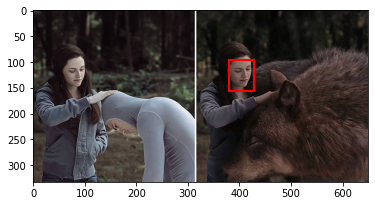

In [367]:
#original image
plt.imshow(x_data[1])
rectangle = patches.Rectangle((y_train1['x_0'][1],y_train1['y_0'][1] ), (y_train1['x_1'][1]-y_train1['x_0'][1]) , (y_train1['y_1'][1]-y_train1['y_0'][1]) , linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rectangle)
plt.axis('scaled')
plt.show()

In [368]:
X_seg_data=[]
# from keras.preprocessing import image
for i in range(len(x_data)):
    print(i)
    X_seg_data.append(resize(x_data[i], (128,128,3)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Image Segmentation: Binary masking of images

In [369]:
##image segementation
from skimage.color import rgb2gray
# img=X_train[0]
# grayscale = rgb2gray(img)

seg_data=[]
for i in range(len(X_seg_data)):
    y_min=int(y_train2['y_0'][i])
    y_max=int(y_train2['y_1'][i])
    x_min=int(y_train2['x_0'][i])
    x_max=int(y_train2['x_1'][i])
    # print(i) 
    img=X_seg_data[i]
  # grayscale = rgb2gray(img)
    target = img[y_min:y_max, x_min:x_max]
    img = np.zeros_like(img)
    img[y_min:y_max, x_min:x_max] = target
    seg_data.append(img)

In [370]:
y_train2[69:70]

,label,height,width,x_0,x_1,y_0,y_1
69,Face,128,128,13.946269,31.331343,33.286863,70.691689


### Validating image segmentation

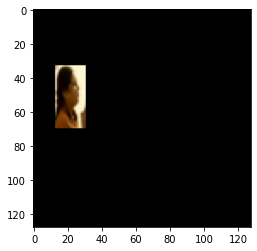

In [371]:
plt.imshow(seg_data[69])

In [372]:
X_seg_data=np.array(seg_data)
X_seg_data.shape

(1132, 128, 128, 3)

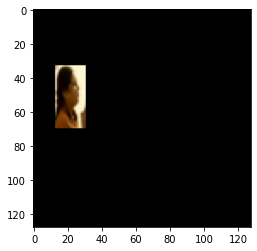

In [373]:
plt.imshow(X_seg_data[69])

In [374]:
train_labels = y_train2['label']
train_bbox = y_train2[['x_0', 'y_0', 'x_1', 'y_1']]

train_bbox=np.array(train_bbox)
len(train_bbox)

1132

In [375]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape, Dense

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
IMAGE_SIZE=128
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=4, name="coords")(x0)
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    x2 = Reshape((4,))(x1) # These are the 4 predicted coordinates of one BBox
     
    # classifier_head = x0
    # classifier_head = Dense(2, activation='softmax', name='label')(classifier_head)

    reg_head = Dense(64, activation='relu')(x0)
    reg_head = Dense(32, activation='relu')(reg_head)
    reg_head = Dense(4, activation='sigmoid', name='bbox')(reg_head)

    return Model(inputs=model.input, outputs=x2)

In [376]:
model = create_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() 

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0   

In [379]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [380]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

In [381]:

from tensorflow.keras import initializers, optimizers
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[IoU])
# Fit the model
model.fit(X_seg_data,train_bbox,validation_split=0.2,epochs=30, batch_size=32)

Epoch 1/30
29/29 [==============================] - 16s 425ms/step - loss: 1009.0876 - IoU: 0.2849 - val_loss: 276.7490 - val_IoU: 0.4530
Epoch 2/30
29/29 [==============================] - 11s 375ms/step - loss: 135.2270 - IoU: 0.5874 - val_loss: 119.4141 - val_IoU: 0.5605
Epoch 3/30
29/29 [==============================] - 11s 377ms/step - loss: 71.6868 - IoU: 0.6846 - val_loss: 90.4616 - val_IoU: 0.6135
Epoch 4/30
29/29 [==============================] - 11s 379ms/step - loss: 51.1687 - IoU: 0.7236 - val_loss: 75.2544 - val_IoU: 0.6364
Epoch 5/30
29/29 [==============================] - 11s 375ms/step - loss: 39.5657 - IoU: 0.7495 - val_loss: 65.0444 - val_IoU: 0.6508
Epoch 6/30
29/29 [==============================] - 11s 374ms/step - loss: 31.9170 - IoU: 0.7730 - val_loss: 58.5407 - val_IoU: 0.6627
Epoch 7/30
29/29 [==============================] - 11s 377ms/step - loss: 26.5026 - IoU: 0.7895 - val_loss: 53.7100 - val_IoU: 0.6750
Epoch 8/30
29/29 [==============================] 

In [382]:
region = model.predict(X_seg_data)
region[1]

array([75.26157 , 37.116047, 86.01418 , 60.768345], dtype=float32)

In [387]:
from keras.preprocessing import image
import numpy as np
img = image.load_img('Part 1Test Data - Prediction Image.jpeg', target_size=(128,128,3))
x = image.img_to_array(img)
# # result = loaded_model.predict(x1)


# # x = image.img_to_array(img)
x1 = np.expand_dims(x, axis=0)
x2 = preprocess_input(x1)
score= model.predict(x2)
print(score)

[[ 48.52483  44.76118 107.67878 121.8227 ]]


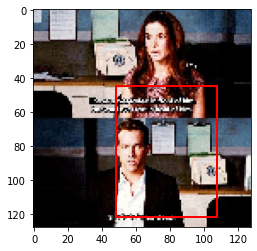

In [385]:
plt.imshow(img)
rectangle = patches.Rectangle((48.52483,44.76118), (107.67878-48.52483) , (121.8227-44.76118) , linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rectangle)
plt.axis('scaled')
plt.show()

### Part 2: Face recognition

In [152]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
import random

In [153]:
# Initialize the random number generator
import random
random.seed(0)

In [ ]:
# file_path="/content/gdrive/MyDrive/Part 3 - Aligned Face Dataset from Pinterest.zip"
# from zipfile import ZipFile

# with ZipFile(file_path, 'r') as z:
#   z.extractall(path="/content/gdrive/MyDrive/")
# print("Training zip extraction done!")

In [154]:
dir=os.getcwd()+'\\Part 3 - Aligned Face Dataset from Pinterest\PINS'
files = os.listdir(dir)
print(files)

['pins_Aaron Paul', 'pins_alexandra daddario', 'pins_Alvaro Morte', 'pins_alycia debnam carey face', 'pins_Amanda Crew', 'pins_Amaury Nolasco', 'pins_amber heard face', 'pins_Anna Gunn', 'pins_anne hathaway', 'pins_barbara palvin face', 'pins_bellamy blake face', 'pins_Benedict Cumberbatch', 'pins_Betsy Brandt', 'pins_bill gates', 'pins_Brenton Thwaites', 'pins_brie larson', 'pins_Brit Marling', 'pins_Bryan Cranston', 'pins_Caity Lotz', 'pins_Cameron Monaghan', 'pins_chadwick boseman face', 'pins_Chance Perdomo', 'pins_Chris Evans', 'pins_Chris Pratt', 'pins_Cobie Smulders', 'pins_Danielle Panabaker', 'pins_Dave Franco', 'pins_david mazouz', 'pins_Dominic Purcell', 'pins_drake', 'pins_dua lipa face', 'pins_Dwayne Johnson', 'pins_eliza taylor', 'pins_elizabeth olsen face', 'pins_elon musk', 'pins_Emilia Clarke', 'pins_Emily Bett Rickards', 'pins_Emma Stone', 'pins_emma watson face', 'pins_gal gadot face', 'pins_grant gustin face', 'pins_Gwyneth Paltrow', 'pins_Henry Cavil', 'pins_jason 

## Check some sample images

Each image in the data set has a same of (299, 299, 3)
The number of features in any image from the data set are: 268203


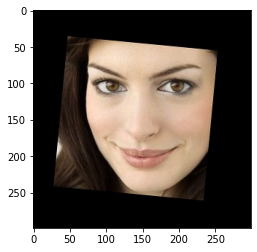

In [155]:
filepath=os.getcwd()+'\\Part 3 - Aligned Face Dataset from Pinterest\PINS'+'\\pins_anne hathaway\\anne hathaway1.jpg'
img = mpimg.imread(filepath)
print("Each image in the data set has a same of {0}".format(img.shape))
flattened_img = img.flatten()
print("The number of features in any image from the data set are: {0}".format(flattened_img.shape[0]))
plt.imshow(img,cmap='gray')

Each image in the data set has a same of (299, 299, 3)
The number of features in any image from the data set are: 268203


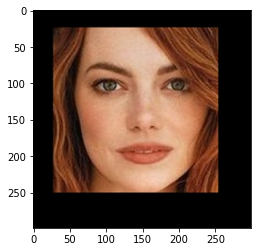

In [156]:
filepath=os.getcwd()+'\\Part 3 - Aligned Face Dataset from Pinterest\PINS'+'\\pins_Emma Stone\\Emma Stone0.jpg'
img = mpimg.imread(filepath)
print("Each image in the data set has a same of {0}".format(img.shape))
flattened_img = img.flatten()
print("The number of features in any image from the data set are: {0}".format(flattened_img.shape[0]))
plt.imshow(img,cmap='gray')

### Create Metadata

In [157]:
images_groups=[]
metadata=[]
labels=[]
neg_image_pair=[]
anchor_image=[]
neg_image_label=[]

for directory in files:
    images = os.listdir(dir+'//'+directory)
    for i in images[:2]:
      img_path=os.path.join(dir, directory, i)
      ext=os.path.splitext(img_path)[1]
      if ext=='.jpg' or ext=='.jpeg':
        metadata.append(img_path)
        labels.append(directory)

#### Taking single image from each folder to create negative pair

In [158]:
unique_img=[]
unique_img_lb=[]
for directory in files:
    images = os.listdir(dir+'//'+directory)
    for i in images[:1]:
      img_path=os.path.join(dir, directory, i)
      ext=os.path.splitext(img_path)[1]
      if ext=='.jpg' or ext=='.jpeg':
        unique_img.append(img_path)
        unique_img_lb.append(directory)

#### Taking 30 images from each folder to create positive pair

In [159]:
pos_unique_img=[]
pos_unique_img_lb=[]
for directory in files:
    images = os.listdir(dir+'//'+directory)
    for i in images[:30]:
      img_path=os.path.join(dir, directory, i)
      ext=os.path.splitext(img_path)[1]
      if ext=='.jpg' or ext=='.jpeg':
        pos_unique_img.append(img_path)
        pos_unique_img_lb.append(directory)

## **Face Detection model**

In [236]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

# Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('sigmoid'))

# # Load VGG Face model weights
# model.load_weights('vgg_face_weights.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_26 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 112, 112, 128)    

### Load weights

In [237]:
weight_path=os.getcwd()+'\\part2'+'\\Part 3 - vgg_face_weights.h5'
model.load_weights(weight_path)

### Image Preprocessing

In [168]:
def preprocess_image(filename):
  img = mpimg.imread(filename)
  img= (img/255.).astype(np.float32)
  img= cv2.resize(img, dsize=(224,224))
  return img

def el_subtraction(x,y):
  distance=np.abs(np.subtract(x,y))
  return distance

In [169]:
from itertools import product
from tqdm import tqdm

#### Getting distance between similar images

In [170]:
embedding_vector_pos_pair=[]
embedding_label_pos_pair=[]
for i in range(100):
  print(i)
  for j in range(30):
    if pos_unique_img_lb[i] == pos_unique_img_lb[j]:
      im1=preprocess_image(pos_unique_img[i])
      embedding_vector1=model.predict(np.expand_dims(im1, axis=0))
      im2=preprocess_image(pos_unique_img[j])
      embedding_vector2=model.predict(np.expand_dims(im2, axis=0))
      distance= el_subtraction(embedding_vector1,embedding_vector2)
      distance=distance.flatten()
      embedding_vector_pos_pair.append(distance)
      embedding_label_pos_pair.append(1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [174]:
len(embedding_vector_pos_pair)

900

In [175]:
30*30

900

#### Getting distance between dissimilar images

In [180]:
embedding_vector_ng_pair=[]
embedding_label_ng_pair=[]
for i in range(30):
    print(i)
    for j in range(30):
#         print(j)
        if unique_img_lb[i] != unique_img_lb[j]:
            im1=preprocess_image(unique_img[i])
            embedding_vector1=model.predict(np.expand_dims(im1, axis=0))
            im2=preprocess_image(unique_img[j])
            embedding_vector2=model.predict(np.expand_dims(im2, axis=0))
            distance= el_subtraction(embedding_vector1,embedding_vector2)
            distance=distance.flatten()
            embedding_vector_ng_pair.append(distance)
            embedding_label_ng_pair.append(0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [181]:
len(embedding_vector_ng_pair)

870

In [209]:
import pandas as pd
all_pairs = embedding_vector_pos_pair + embedding_vector_ng_pair
all_labels = embedding_label_pos_pair + embedding_label_ng_pair
all_pairs=np.array(all_pairs)
all_labels=np.array(all_labels)


data=pd.DataFrame(all_pairs)
data_label=pd.DataFrame(all_labels, columns=['target'])
# data.shape
# data.head()
# data_label.head(12)
# ana_data=pd.concat([data,data_label], axis=1 )
# ana_data['target'].value_counts()

In [210]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
train_X, test_X, train_y, test_y = train_test_split(data, data_label, test_size=0.30, random_state=0)

In [211]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [212]:
pca = PCA(n_components=0.95) # need a component to get 95% of explained variance 
pca.fit(train_X)

PCA(n_components=0.95)

In [215]:
train_img = pca.transform(train_X)
test_img = pca.transform(test_X)


In [217]:
#hyperparameter tunning for SVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC()

parameters = {
              'kernel' :['poly', 'rbf', 'sigmoid'], 
              'C': [0.1, 0.4, 0.8, 1, 2, 5,10,20,30]
              }

grid_search=GridSearchCV(estimator=svc ,param_grid=parameters,cv=10,n_jobs=-1,verbose=2)
grid_search.fit(train_img,train_y)

print(grid_search.best_params_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
{'C': 2, 'kernel': 'rbf'}


C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [240]:
model_svm=SVC(C=2, kernel= 'rbf')
model_svm.fit(train_img, train_y)   # fit the model with the train data
y_pred = model_svm.predict(test_img)  # make predictions on the test set
score = round(model_svm.score(test_img, test_y), 3)

C:\Users\rajhi\anaconda3\envs\test2\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [220]:
## Test images

In [239]:
img=os.getcwd()+"\part2\Part 2 Test Images\Part 2 Test Images\Part_2-_Test_Image_-_Benedict_Cumberbatch9.jpg"
img2=os.getcwd()+"\part2\Part 2 Test Images\Part 2 Test Images\Part_2_-_Test_Image_-_Dwayne_Johnson4.jpg"
im1=preprocess_image(img)
embedding_vector1=model.predict(np.expand_dims(im1, axis=0))
im2=preprocess_image(img2)
embedding_vector2=model.predict(np.expand_dims(im2, axis=0))
distance= el_subtraction(embedding_vector1,embedding_vector2)
distance=distance.flatten()

In [268]:
dis=distance.reshape(1,-1)
test_data=pd.DataFrame(dis)
test_img = pca.transform(test_data)
y_pred = model_svm.predict(test_img)

C:\Users\rajhi\Manasi\Computer Vision\computer vision\facedetection\part2\Part 2 Test Images\Part 2 Test Images\Part_2-_Test_Image_-_Benedict_Cumberbatch9.jpg


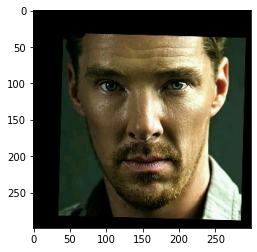

In [278]:
filepath=os.getcwd()+"\part2\Part 2 Test Images\Part 2 Test Images\Part_2-_Test_Image_-_Benedict_Cumberbatch9.jpg"
print(filepath)
img2 = mpimg.imread(filepath)
plt.imshow(img2,cmap='gray')

C:\Users\rajhi\Manasi\Computer Vision\computer vision\facedetection\part2\Part 2 Test Images\Part 2 Test Images\Part_2_-_Test_Image_-_Dwayne_Johnson4.jpg


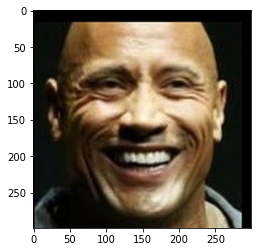

In [279]:
filepath=os.getcwd()+"\part2\Part 2 Test Images\Part 2 Test Images\Part_2_-_Test_Image_-_Dwayne_Johnson4.jpg"
print(filepath)
img = mpimg.imread(filepath)
plt.imshow(img,cmap='gray')

In [269]:
y_pred

array([0])

Summary two test images are different

In [270]:
img=os.getcwd()+"\part2\Part 2 Test Images\Part 2 Test Images\Part_2-_Test_Image_-_Benedict_Cumberbatch9.jpg"
img2=os.getcwd()+"\part2\Part 2 Test Images\Part 2 Test Images\Part_2-_Test_Image_-_Benedict_Cumberbatch9.jpg"
im1=preprocess_image(img)
embedding_vector1=model.predict(np.expand_dims(im1, axis=0))
im2=preprocess_image(img2)
embedding_vector2=model.predict(np.expand_dims(im2, axis=0))
distance= el_subtraction(embedding_vector1,embedding_vector2)
distance=distance.flatten()

In [271]:
dis=distance.reshape(1,-1)
test_data=pd.DataFrame(dis)
test_img = pca.transform(test_data)
y_pred = model_svm.predict(test_img)


array([1])

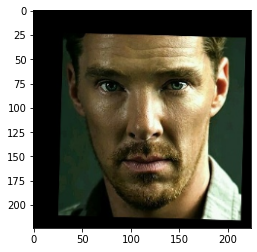

In [273]:
plt.imshow(im1)

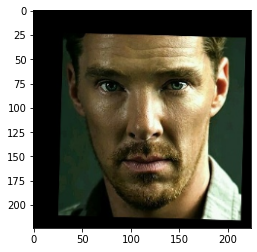

In [274]:
plt.imshow(im2)

In [275]:
y_pred

array([1])

### Summary Both the images are similar